In [1]:
import pickle
from typing import Union
from pathlib import Path
import shutil

import astropy.constants as c
from astropy.io import fits
import astropy.units as u
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import gofish as gf
from regions import CircleSkyRegion
from scipy.integrate import simpson
from scipy.interpolate import interp1d
from scipy.ndimage import shift
from spectral_cube import SpectralCube

Fixed variables.

In [2]:
obs_path = Path('./observations/')

distance = 56 * u.pc
incl = 0
PA = 0

In [3]:
(1 * u.arcsec).to_value(u.rad) * distance.to(u.au)

<Quantity 56. AU>

In [4]:
def cube_window(fits_path: Union[str, Path], window: u.au)-> SpectralCube:
    """
    Return a SpectralCube instance zoomed into the window
    Parameters
    ----------
    fits_path: Union[str, Path]
    window: u.au

    Returns
    -------

    """
    cube = SpectralCube.read(fits_path, format='fits')
    cube.allow_huge_operations = True

    # select the spatial disk region from the original file
    center = cube.wcs.celestial.pixel_to_world(cube.shape[1] / 2, cube.shape[2] / 2)
    radius = (window / distance).to(
        u.arcsec, equivalencies=u.dimensionless_angles()
    )
    region = CircleSkyRegion(center, radius)

    return cube.subcube_from_regions([region])

def lbp(r: float, m_disk: float, r_c: float, gamma: float = 1) -> float:
    """
    Calculate the self-similar Lynden-Bell & Pringle surface density.
    
    Parameters
    ----------
    r: float
        Radius where to evaluate the surface density.
    m_disk: float
        Total disk mass.
    r_c: float
        Tapering radius.
    gamma: float
        Tapering factor

    Returns
    -------

    """
    return m_disk / (2 * np.pi * r**2) * (r / r_c)**(-gamma) * np.exp(-r / r_c)

### Anthony file
15 microns

In [5]:
fits_ant = obs_path / 'image_amoeba_F1550C_sum4.fits'
pixelsize = (0.11 * u.arcsec).to_value(u.deg)
lam = 15e-4  # cm
beam = (None, None, None)

#  modify fits file to add missing info
fits_ant_mod = Path(str(fits_ant).replace('.fits', '_mod.fits'))
shutil.copy(fits_ant, fits_ant_mod)

fits.setval(fits_ant_mod, 'cdelt1', value=-pixelsize)
fits.setval(fits_ant_mod, 'cdelt2', value=pixelsize)
fits.setval(fits_ant_mod, 'crpix1', value=fits.getval(fits_ant, 'naxis1') // 2 + 0.5)
fits.setval(fits_ant_mod, 'crpix2', value=fits.getval(fits_ant, 'naxis2') // 2 + 0.5)
fits.setval(fits_ant_mod, 'crval1', value=0.0)
fits.setval(fits_ant_mod, 'crval2', value=0.0)
fits.setval(fits_ant_mod, 'BUNIT', value='arbitrary units')

#  load data and show header
with fits.open(fits_ant_mod) as hdul:
    data_ant_mod = hdul[0].data

Check if image is centered.

Text(0.5, 1.0, 'Center at 15 $\\mu$m')

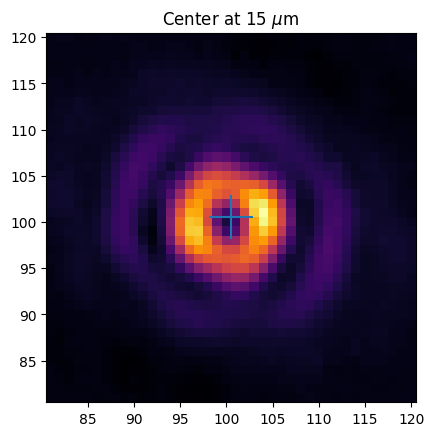

In [6]:
f, ax = plt.subplots()
# im = ax.imshow(imcube.data, cmap='inferno', origin='lower', extent=imcube.extent)
im = ax.imshow(data_ant_mod, cmap='inferno', origin='lower')
window = 20
ax.set_xlim(fits.getval(fits_ant_mod, 'crpix1') + np.array([- window, window]))
ax.set_ylim(fits.getval(fits_ant_mod, 'crpix2') + np.array([- window, window]))
ax.scatter(fits.getval(fits_ant_mod, 'crpix1'), fits.getval(fits_ant_mod, 'crpix2'), marker='+', s=1000)
ax.set_title(r'Center at 15 $\mu$m')


Load cube. The subtraction of the reference star is wrong, therefore replace negative numbers from oversubtraction with zeros.

In [7]:
imcube_ant = gf.imagecube(fits_ant_mod, FOV=10)
#  Replace negative numbers with zeros
imcube_ant.data = np.where(imcube_ant.data > 0, imcube_ant.data, 0.)

Select masks without artifacts to extract radial profiles.

Text(0.5, 1.0, 'Mask for 15 $\\mu$m image')

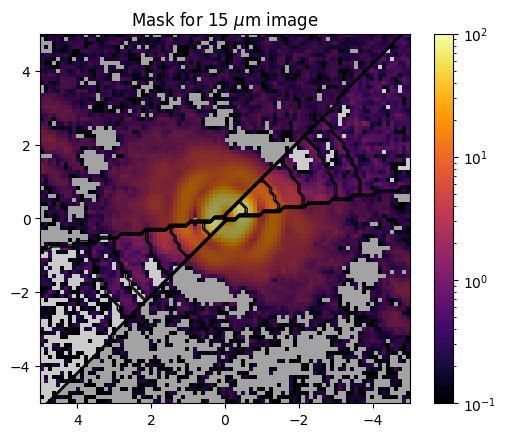

In [8]:
f, ax = plt.subplots()
norm = colors.LogNorm(vmin=0.1, vmax=100)
# extent_au = (imcube_ant.extent << u.arcsec).to_value(u.rad) * distance.to_value(u.au)
im = ax.imshow(imcube_ant.data, cmap='inferno', norm=norm, origin='lower', extent=imcube_ant.extent)
masks = {
    'A': {'PA_min': 100, 'PA_max': 136},
    'B': {'PA_min': -80, 'PA_max': -44}
}

for _mask in masks.values():
    imcube_ant.plot_mask(ax=ax, inc=0, PA=0, mask_alpha=0.2, **_mask)

rings_loc = (((np.array([32, 80, 120, 172, 210]) << u.au)/distance.to(u.au)).value * u.rad).to_value(u.arcsec)
for _ring in rings_loc:
    imcube_ant.plot_mask(ax=ax, mask_alpha=0, r_max=_ring, PA_min=100, PA_max=136)
    imcube_ant.plot_mask(ax=ax, mask_alpha=0, r_max=_ring, PA_min=-80, PA_max=-44)

cb =plt.colorbar(im)
ax.set_title(r'Mask for 15 $\mu$m image')

Extract and plot radial profiles.

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


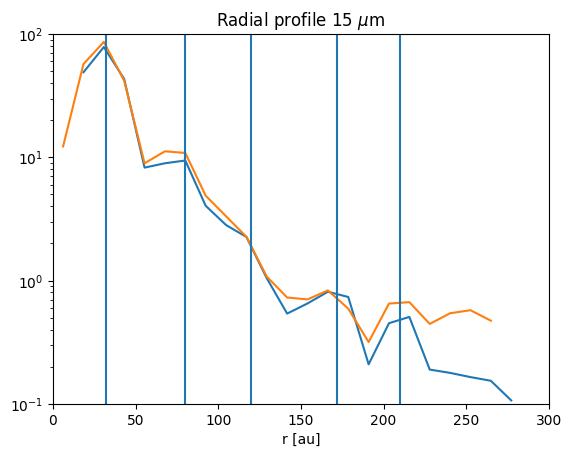

In [9]:
f, ax = plt.subplots()

profiles_ant = {}
for _key, _mask in masks.items():
    x_ant, y_ant, dy_ant = imcube_ant.radial_profile(inc=incl, PA=PA, **_mask)
    #  The profiles are slightly offset, re-aline by shifting the x coordinate.
    if _key == 'A':
        x_ant += 0.22
    profiles_ant[_key] = {'x': x_ant, 'y': y_ant, 'dy': dy_ant}
    x_ant = ((x_ant * u.arcsec).to_value(u.rad, equivalencies=u.dimensionless_angles()) * distance).to(u.au)
    profiles_ant[_key]['x'] = x_ant
    ax.semilogy(x_ant, y_ant)
rings_loc = [32, 80, 120, 172, 210]
ax.vlines(rings_loc, 0.3 * y_ant.min(), 1.2 * y_ant.max())
ax.set_xlabel('r [au]')
ax.set_title(r'Radial profile 15 $\mu$m')
ax.set_xlim(0, 300)
ax.set_ylim(1e-1, 1e2)

fname_out = Path('./profile_ant.pickle')
with open(fname_out, 'wb') as f:
    pickle.dump(profiles_ant, f)

### Andrews CO data

In [10]:
fits_CO = obs_path / 'dataverse_TWHya_CO_cube.fits'

# Zoom in
window = 230 * u.au
cube_CO = cube_window(fits_CO, window)

CO_m0 = cube_CO.with_spectral_unit(u.km / u.s, velocity_convention="radio").moment0()

Peak brightness

Text(0.5, 1.0, 'CO Peak brightness')

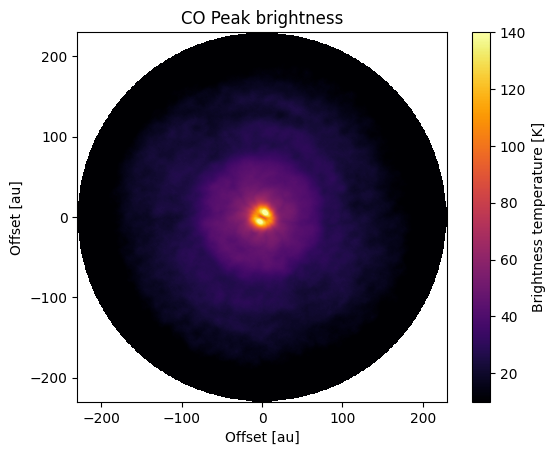

In [11]:
# Plot peak
im_peak = cube_CO.to(u.K).with_spectral_unit(u.km / u.s, velocity_convention="radio").max(axis=0).value
f, ax = plt.subplots()

window = 230 * u.au
extent = list(window.value * np.array([-1, 1, -1, 1]))
norm = colors.Normalize(vmin=10, vmax=140)
im = ax.imshow(im_peak, origin='lower', extent=extent, norm=norm, cmap='inferno')
cb = plt.colorbar(im, label='Brightness temperature [K]')

ax.set_xlabel('Offset [au]')
ax.set_ylabel('Offset [au]')
ax.set_title(r'CO Peak brightness')

Moment 0

Text(0.5, 1.0, 'CO moment 0')

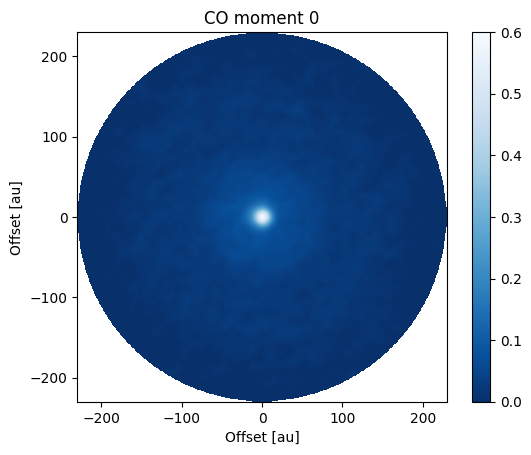

In [12]:
f, ax = plt.subplots()

window = 230 * u.au
extent = list(window.value * np.array([-1, 1, -1, 1]))
norm = colors.Normalize(vmin=0, vmax=0.6)
im = ax.imshow(CO_m0.value, origin='lower', extent=extent, norm=norm, cmap='Blues_r')
cb = plt.colorbar(im)

ax.set_xlabel('Offset [au]')
ax.set_ylabel('Offset [au]')
ax.set_title(r'CO moment 0')

Extract radial profile

In [13]:
fov = ((2 * window / distance).decompose() * u.rad).to(u.arcsec).value
imcube_CO = gf.imagecube(fits_CO, FOV=fov)
x_CO, y_CO, dy_CO = imcube_CO.radial_profile(inc=incl, PA=PA)
x_CO = (x_CO * u.arcsec).to_value(u.rad, equivalencies=u.dimensionless_angles()) * distance.to(u.au)

The features more or less match with a radial offset of -26 au

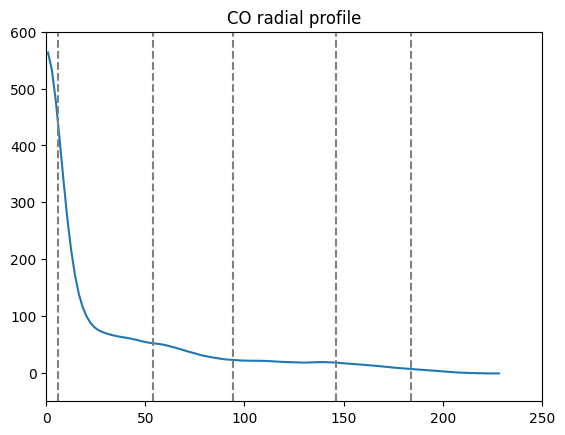

In [14]:
f, ax = plt.subplots()
ax.plot(x_CO, y_CO)
ax.vlines(np.array(rings_loc) - 26, -50, 600, colors='gray', ls='--')
ax.set_ylim(-50, 600)
ax.set_xlim(0, 250)
ax.set_title('CO radial profile')

profile_CO = {
    'x': x_CO.cgs.value,
    'y': y_CO,
    'dy': dy_CO,
}
# save profile to use in dustpy initialization  
fname_out = Path('./profile_CO.pickle')
with open(fname_out, 'wb') as f:
    pickle.dump(profile_CO, f)

### Andrews 870 micron data

In [15]:
fits_870_micron = obs_path / 'TWHya.ALMA_band7.30mas.fits'
lam = 870 * u.micron

with fits.open(fits_870_micron) as hdul:
    data_870_micron = hdul[0].data[0, 0, ::]
    display(hdul[0].data.shape)

(1, 1, 2048, 2048)

recenter and plot

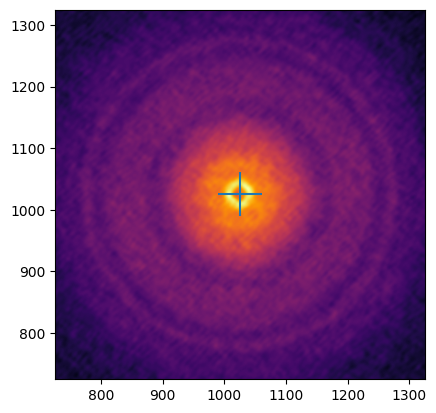

In [16]:
f, ax = plt.subplots()
# im = ax.imshow(imcube.data, cmap='inferno', origin='lower', extent=imcube.extent)
shifted_data = shift(data_870_micron, [-3, 4], order=0)
im = ax.imshow(shifted_data, cmap='inferno', origin='lower')
window = 300
ax.set_xlim(fits.getval(fits_870_micron, 'crpix1') + np.array([- window, window]))
ax.set_ylim(fits.getval(fits_870_micron, 'crpix2') + np.array([- window, window]))
ax.scatter(fits.getval(fits_870_micron, 'crpix1'), fits.getval(fits_870_micron, 'crpix2'), marker='+', s=1000)

Extract radial profile

In [17]:
#  modify fits file recenter and convert to brightness temperature units
fits_870_micron_mod = Path(str(fits_870_micron).replace('.fits', '_mod.fits'))
shutil.copy(fits_870_micron, fits_870_micron_mod)

with fits.open(fits_870_micron_mod, mode='update') as hdul:
    hdul[0].data[0, 0, ::] = shifted_data
    hdul.flush()
    
cube_870_micron = SpectralCube.read(fits_870_micron_mod).to(u.K)
cube_870_micron.write(fits_870_micron_mod, format='fits', overwrite=True)

Text(0.5, 1.0, '870 $\\mu$m')

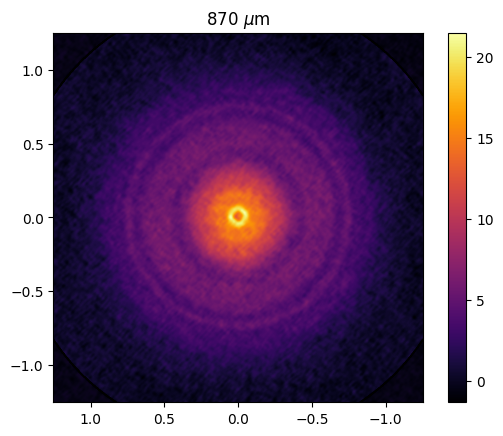

In [18]:
imcube_870_micron = gf.imagecube(fits_870_micron_mod, FOV=2.5)

f, ax = plt.subplots()
im = ax.imshow(imcube_870_micron.data, cmap='inferno', origin='lower', extent=imcube_870_micron.extent)

for _mask in masks.values():
    imcube_870_micron.plot_mask(ax=ax, r_min=0, r_max=1.5, inc=0, PA=0, mask_alpha=0.3)
cb = plt.colorbar(im)
ax.set_title(r'870 $\mu$m')

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Text(0.5, 1.0, 'Brightness profile 870 $\\mu$m')

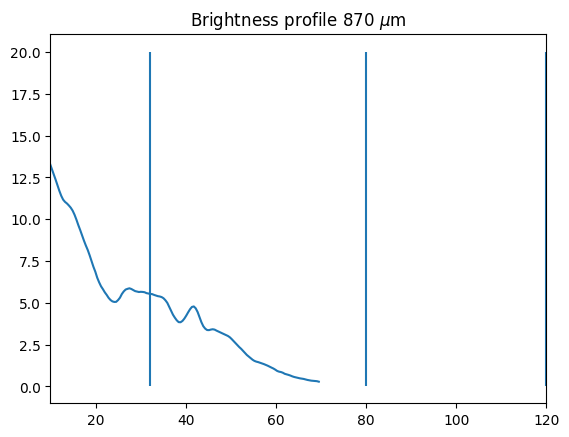

In [19]:
x_870_micron, y_870_micron, dy_870_micron = imcube_870_micron.radial_profile(inc=incl, PA=PA, mstar=1, dist=distance.to_value(u.pc))
x_870_micron = (x_870_micron * u.arcsec).to_value(u.rad) * distance.to(u.au)

profile_870_micron = {
    'x': x_870_micron.cgs.value,
    'y': y_870_micron,
    'dy': dy_870_micron,
}
fname_out = Path('./profile_870_micron.pickle')
with open(fname_out, 'wb') as f:
    pickle.dump(profile_870_micron, f)

f, ax = plt.subplots()
ax.plot(x_870_micron, y_870_micron)
ax.vlines(rings_loc, 0, 20)
ax.set_xlim(10, 120)
ax.set_title(r'Brightness profile 870 $\mu$m')

In [20]:
profiles_ant

{'A': {'x': <Quantity [ 18.48,  30.8 ,  43.12,  55.44,  67.76,  80.08,  92.4 , 104.72,
             117.04, 129.36, 141.68, 154.  , 166.32, 178.64, 190.96, 203.28,
             215.6 , 227.92, 240.24, 252.56, 264.88, 277.2 ] AU>,
  'y': array([49.02259   , 78.55476   , 43.16623   ,  8.251139  ,  8.948322  ,
          9.42178   ,  4.0453444 ,  2.820546  ,  2.2577016 ,  1.0434222 ,
          0.53895015,  0.6514659 ,  0.8108153 ,  0.73500097,  0.20879324,
          0.45034117,  0.50647444,  0.18925716,  0.17794383,  0.16450581,
          0.15355614,  0.10638986], dtype=float32),
  'dy': array([5.7567644 , 1.3558085 , 2.4615018 , 0.77650195, 0.29663   ,
         0.343962  , 0.20123342, 0.11036806, 0.13813645, 0.05850181,
         0.04542203, 0.05288436, 0.02736616, 0.02963508, 0.0192728 ,
         0.02209336, 0.0160672 , 0.01303187, 0.0120388 , 0.01083087,
         0.01439176, 0.00950562], dtype=float32)},
 'B': {'x': <Quantity [  6.16,  18.48,  30.8 ,  43.12,  55.44,  67.76,  80.08,  92.4

Edge of the 850 micron dust emission

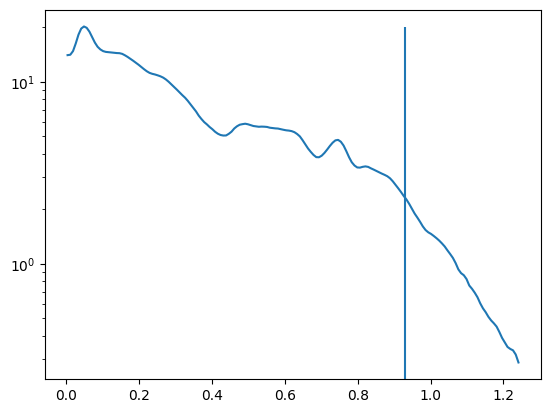

In [40]:
plt.semilogy(((x_870_micron / distance).cgs * u.rad).to(u.arcsec), y_870_micron)
plt.vlines([0.93], 0, 20)

### Hideko C180

In [22]:
fits_C18O = Path(r'./observations/Nomura_C180.fits')

with fits.open(fits_C18O) as hdul:
    data_C18O = hdul[0].data[0, 0, ::]

Text(0.5, 1.0, 'Center C18O')

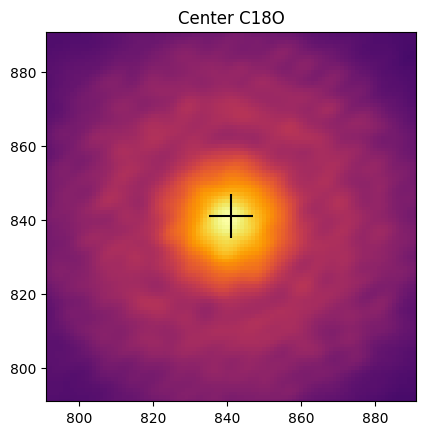

In [23]:
# Check center
f, ax = plt.subplots()

# im = ax.imshow(imcube.data, cmap='inferno', origin='lower', extent=imcube.extent)
shifted_data = shift(data_C18O, [-1, -3], order=0)
im = ax.imshow(shifted_data, cmap='inferno', origin='lower')
window = 50
ax.set_xlim(fits.getval(fits_C18O, 'crpix1') + np.array([- window, window]))
ax.set_ylim(fits.getval(fits_C18O, 'crpix2') + np.array([- window, window]))
ax.scatter(fits.getval(fits_C18O, 'crpix1'), fits.getval(fits_C18O, 'crpix2'), marker='+', s=1000, c='k')
ax.set_title(r'Center C18O')


In [24]:
#  modify fits file recenter and convert to brightness temperature units
fits_C180_mod = Path(str(fits_C18O).replace('.fits', '_mod.fits'))
shutil.copy(fits_C18O, fits_C180_mod)

with fits.open(fits_C180_mod, mode='update') as hdul:
    hdul[0].data[0, 0, ::] = shifted_data
    hdul.flush()
    
cube_C18O = SpectralCube.read(fits_C180_mod).to(u.K)
cube_C18O.write(fits_C180_mod, format='fits', overwrite=True)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


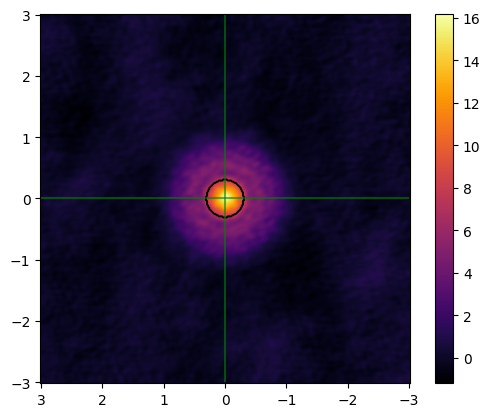

In [25]:
fov= 6
imcube_C18O = gf.imagecube(fits_C180_mod, FOV=fov)
x_C18O, y_C18O, dy_C18O = imcube_C18O.radial_profile(inc=7, PA=PA)
x_C18O = (x_C18O * u.arcsec).to_value(u.rad, equivalencies=u.dimensionless_angles()) * distance.to(u.au)

f, ax = plt.subplots()
im = ax.imshow(imcube_C18O.data, origin='lower', extent=imcube_C18O.extent, cmap='inferno')
imcube_C18O.plot_mask(r_max=0.3, ax=ax, mask_alpha=0)
cb = plt.colorbar(im)
ax.vlines(0, -fov/2, fov/2, colors='green', alpha=0.6)
ax.hlines(0, -fov/2, fov/2, colors='green', alpha=0.6)

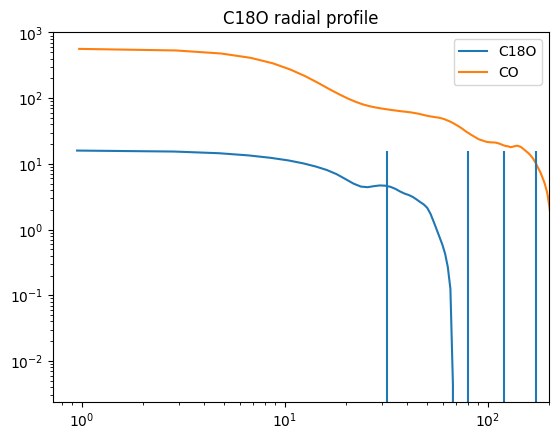

In [26]:
f, ax = plt.subplots()
ax.loglog(x_C18O, y_C18O, label='C18O')
ax.loglog(x_CO, y_CO, label='CO')
ax.vlines(np.array(rings_loc), 0.5 * y_C18O.min(), y_C18O.max())
ax.set_title('C18O radial profile')
ax.set_xlim(0, 200)
ax.legend()

In [27]:
# save profile to use in dustpy initialization 

profile_C18O = {
    'x': x_C18O.cgs.value,
    'y': y_C18O,
    'dy': dy_C18O,
}

fname_out = Path('./profile_C18O.pickle')
with open(fname_out, 'wb') as f:
    pickle.dump(profile_C18O, f)

In [28]:
def interp_profile_norm(radius: float, profile_dict: dict, total_disk_mass: float) -> float:
    """
    Interpolate a profile to use as gas surface density, normalized to a given total disk mass.
    
    Parameters
    ----------
    radius: float
        Radius where to evaluate the gas surface density.
    profile_dict: dict
        Dictionary containing the profile to use as surface density distribution. The keys must be named 'x' and 'y'.
    total_disk_mass: float
        Total disk mass.
        
    Returns
    -------
    float
        Normalized gas surface density at radius 'radius'.
    """
    
    normalization_constant = total_disk_mass / simpson(2 * np.pi * profile_dict['x'] * profile_dict['y'], profile_dict['x'])
    interp_profile = interp1d(profile_dict['x'], profile_dict['y'], fill_value='extrapolate', kind='quadratic')
    
    return normalization_constant * interp_profile(radius)

In [29]:
# r_c = (30 * u.au).cgs.value
# 
# m_disk = (0.11 * c.M_sun).cgs.value
# param = np.linspace(0.001, 0.11, 10) * c.M_sun.cgs.value
# for m_disk in param:
#     f, ax = plt.subplots()
#     profile_lbp = lbp(profile_C18O['x'], m_disk, r_c, 1)
#     ax.plot(profile_C18O['x'], profile_lbp, label='lbp')
#     
#     y_C18O_norm = interp_profile_norm(profile_C18O['x'], profile_C18O, m_disk)
#     ax.plot(profile_C18O['x'], y_C18O_norm, label='C18O')
#     
#     ax.legend()

In [30]:
# params = np.array([0.1])* c.M_sun.cgs.value
# params = np.linspace(0.0001, 1.11, 10) * c.M_sun.cgs.value
# 
# for _param in params:
#     m_disk = (_param * c.M_sun).cgs.value
#     r_c = (30 * u.au).cgs.value
#     
#     f, ax = plt.subplots()
#     profile_lbp = lbp(profile_CO['x'], _param, r_c, 1)
#     ax.plot(profile_CO['x'], profile_lbp, label=f'lbp {_param / c.M_sun.cgs.value:.2f}')
#     
#     y_CO_norm = interp_profile_norm(profile_CO['x'], profile_CO, _param)
#     ax.plot(profile_CO['x'], y_CO_norm, label='CO')
# 
#     # plt.xlim(0, 3.5e15)
#     ax.set_ylim(-1, 100)
#     ax.legend()
#     plt.show()

Model quicklook

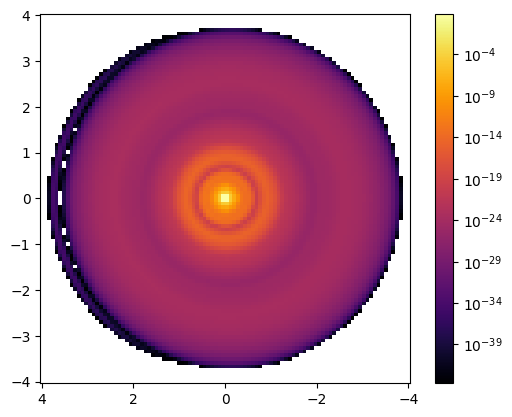

In [31]:
model_path = Path('models/model_0.5_3_0.087') / 'radmc_run' / 'image.fits'
imcube_model = gf.imagecube(model_path)

f, ax = plt.subplots()
norm = colors.LogNorm()
im = ax.imshow(imcube_model.data, origin='lower', extent=imcube_model.extent, cmap='inferno', norm=norm)
cb = plt.colorbar(im)